# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/emaminotti/ID2223-ScalableMLDL
HopsworksSettings initialized!


In [9]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os
from collections import deque

In [ ]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 10, 2, 49, 451133)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()

location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
sensor_config = json.loads(location_str)
streets = [cfg["street"] for cfg in sensor_config.values()]
print(f"✅ Loaded configuration for {len(streets)} sensors: {streets}")
country = settings.AQICN_COUNTRY
city = settings.AQICN_CITY

2025-11-18 10:02:49,479 INFO: Initializing external client
2025-11-18 10:02:49,480 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 10:02:50,110 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 10:02:50,947 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1267872
✅ Loaded configuration for 2 sensors: ['radhuset', 'dalaplan']


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
import joblib

mr = project.get_model_registry()
retrieved_models = {}
fv = None

for sensor_name, cfg in sensor_config.items():
    street_name = cfg["street"]
    
    model_name = f"air_quality_xgboost_{street_name}"
    
    print(f"   - Loading model for: {sensor_name} ({street_name}) -> {model_name}")
    
    try:
        retrieved_model_registry = mr.get_model(
            name=model_name,
            version=1, 
        )
        
        if fv is None:
            fv = retrieved_model_registry.get_feature_view()
            print(f"   - Retrieved Feature View.")

        saved_model_dir = retrieved_model_registry.download()

        model_path = os.path.join(saved_model_dir, "model.pkl")
        retrieved_xgboost_model = joblib.load(model_path)
        
        retrieved_models[street_name] = retrieved_xgboost_model
        
        print(f"   - Model for '{street_name}' loaded successfully.")

    except Exception as e:
        print(f"   - ⚠️ Error while retrieving the model '{model_name}': {e}")

   - Loading model for: radhuset (radhuset) -> air_quality_xgboost_radhuset
2025-11-18 10:02:53,196 INFO: There is no parent information
   - Retrieved Feature View.


Downloading: 0.000%|          | 0/2389182 elapsed<00:00 remaining<?

   - Model for 'radhuset' loaded successfully.. DONE
   - Loading model for: dalaplan (dalaplan) -> air_quality_xgboost_dalaplan
2025-11-18 10:02:56,448 INFO: There is no parent information
   - Retrieved Feature View.


Downloading: 0.000%|          | 0/2384964 elapsed<00:00 remaining<?

   - Model for 'dalaplan' loaded successfully.. DONE


## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [6]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=2,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.15s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,humidity_mean,city
0,2025-11-20 00:00:00+00:00,2.8,4.4,29.2,317,86,Malmo
1,2025-11-22 00:00:00+00:00,5.1,0.0,26.7,239,85,Malmo
2,2025-11-19 00:00:00+00:00,4.1,12.9,15.8,212,88,Malmo
3,2025-11-23 00:00:00+00:00,4.4,0.2,18.6,264,89,Malmo
4,2025-11-21 00:00:00+00:00,3.0,0.0,21.0,291,72,Malmo
5,2025-11-24 00:00:00+00:00,3.8,0.4,15.4,30,91,Malmo


In [7]:
rename_map = {
    'temperature_2m_mean': 'weather_temperature_2m_mean',
    'precipitation_sum': 'weather_precipitation_sum',
    'wind_speed_10m_max': 'weather_wind_speed_10m_max',
    'wind_direction_10m_dominant': 'weather_wind_direction_10m_dominant',
    'humidity_mean': 'weather_humidity_mean'
}

model_feature_names = [
    'pm25_lag_1', 
    'pm25_lag_2', 
    'pm25_lag_3', 
    'weather_temperature_2m_mean', 
    'weather_precipitation_sum', 
    'weather_wind_speed_10m_max', 
    'weather_wind_direction_10m_dominant', 
    'weather_humidity_mean'
]

batch_data = batch_data.rename(columns=rename_map)
batch_data


,date,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,weather_humidity_mean,city
0,2025-11-20 00:00:00+00:00,2.8,4.4,29.2,317,86,Malmo
1,2025-11-22 00:00:00+00:00,5.1,0.0,26.7,239,85,Malmo
2,2025-11-19 00:00:00+00:00,4.1,12.9,15.8,212,88,Malmo
3,2025-11-23 00:00:00+00:00,4.4,0.2,18.6,264,89,Malmo
4,2025-11-21 00:00:00+00:00,3.0,0.0,21.0,291,72,Malmo
5,2025-11-24 00:00:00+00:00,3.8,0.4,15.4,30,91,Malmo


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [12]:
# 2️⃣ Feature group con i dati storici di qualità dell'aria
air_quality_fg = fs.get_feature_group(
    name="air_quality",   # <-- metti il nome giusto se diverso
    version=2             # <-- idem per la versione
)

all_sensors_forecasts = []

for sensor_name, cfg in sensor_config.items():
    street_name = cfg["street"]
    print(f"\n📍 Elaboro sensore: {sensor_name} (street = {street_name})")

    # 3️⃣ Recupero gli ultimi 3 giorni storici di pm25 per questo sensore
    #    (prima di 'today')
    hist_df = (
        air_quality_fg
        .filter(
            (air_quality_fg.street == street_name) &
            (air_quality_fg.date < today)   # ieri, l'altro ieri, ecc.
        )
        .read()
        .sort_values("date")
    )

    if "pm25" not in hist_df.columns:
        raise ValueError("Nel feature group air_quality manca la colonna 'pm25'")

    last_3 = hist_df.tail(3)

    if len(last_3) < 3:
        print(f"⚠️ Non ci sono abbastanza dati storici per '{street_name}' (trovati {len(last_3)}). Skipping.")
        continue

    # Ordine: [d-3, d-2, d-1]
    lag_values = deque(last_3["pm25"].tolist(), maxlen=3)
    print(f"   - Lags iniziali per {street_name}: {list(lag_values)}")

    # 4️⃣ Copio il meteo e aggiungo la colonna 'street' per questo sensore
    sensor_future = batch_data.copy()
    sensor_future["street"] = street_name

    # Mi assicuro che le righe siano in ordine cronologico
    sensor_future = sensor_future.sort_values("date").reset_index(drop=True)

    # Colonna per il valore previsto di pm2.5
    sensor_future["pm25_pred"] = None

    model = retrieved_models.get(street_name)
    if model is None:
        print(f"   - ⚠️ Nessun modello trovato per '{street_name}', salto.")
        continue

    # 5️⃣ Previsione ricorsiva giorno per giorno
    for i, row in sensor_future.iterrows():
        # Costruisco il vettore delle feature per questo giorno
        feature_dict = {
            "pm25_lag_1": lag_values[-1],
            "pm25_lag_2": lag_values[-2],
            "pm25_lag_3": lag_values[-3],
            "weather_temperature_2m_mean": row["weather_temperature_2m_mean"],
            "weather_precipitation_sum": row["weather_precipitation_sum"],
            "weather_wind_speed_10m_max": row["weather_wind_speed_10m_max"],
            "weather_wind_direction_10m_dominant": row["weather_wind_direction_10m_dominant"],
            "weather_humidity_mean": row["weather_humidity_mean"],
        }

        X = pd.DataFrame([feature_dict])[model_feature_names]

        # Predizione pm2.5 per quel giorno
        y_pred = float(model.predict(X)[0])

        # Salvo le lag e la predizione nella tabella
        sensor_future.at[i, "pm25_lag_1"] = feature_dict["pm25_lag_1"]
        sensor_future.at[i, "pm25_lag_2"] = feature_dict["pm25_lag_2"]
        sensor_future.at[i, "pm25_lag_3"] = feature_dict["pm25_lag_3"]
        sensor_future.at[i, "pm25_pred"] = y_pred

        # Aggiorno i lag per il giorno successivo: tolgo il più vecchio, aggiungo la predizione
        lag_values.append(y_pred)

    print(f"   - Generate {len(sensor_future)} forecasts for '{street_name}'")

    all_sensors_forecasts.append(sensor_future)

# 6️⃣ DataFrame finale con previsioni per tutti i sensori
forecast_df = pd.concat(all_sensors_forecasts, ignore_index=True)

forecast_df


📍 Elaboro sensore: radhuset (street = radhuset)
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.04s) 
   - Lags iniziali per radhuset: [15.0, 13.0, 13.0]
   - Generate 6 forecasts for 'radhuset'

📍 Elaboro sensore: dalaplan (street = dalaplan)
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.10s) 
   - Lags iniziali per dalaplan: [13.0, 15.0, 12.0]
   - Generate 6 forecasts for 'dalaplan'


,date,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,weather_humidity_mean,city,street,pm25_pred,pm25_lag_1,pm25_lag_2,pm25_lag_3
0,2025-11-19 00:00:00+00:00,4.1,12.9,15.8,212,88,Malmo,radhuset,25.209545,13.000000,13.000000,15.000000
1,2025-11-20 00:00:00+00:00,2.8,4.4,29.2,317,86,Malmo,radhuset,14.218984,25.209545,13.000000,13.000000
2,2025-11-21 00:00:00+00:00,3.0,0.0,21.0,291,72,Malmo,radhuset,18.665665,14.218984,25.209545,13.000000
3,2025-11-22 00:00:00+00:00,5.1,0.0,26.7,239,85,Malmo,radhuset,26.256144,18.665665,14.218984,25.209545
4,2025-11-23 00:00:00+00:00,4.4,0.2,18.6,264,89,Malmo,radhuset,30.990761,26.256144,18.665665,14.218984
5,2025-11-24 00:00:00+00:00,3.8,0.4,15.4,30,91,Malmo,radhuset,30.569246,30.990761,26.256144,18.665665
6,2025-11-19 00:00:00+00:00,4.1,12.9,15.8,212,88,Malmo,dalaplan,21.568316,12.000000,15.000000,13.000000
7,2025-11-20 00:00:00+00:00,2.8,4.4,29.2,317,86,Malmo,dalaplan,13.082499,21.568316,12.000000,15.000000
8,2025-11-21 00:00:00+00:00,3.0,0.0,21.0,291,72,Malmo,dalaplan,16.265356,13.082499,21.568316,12.000000
9,2025-11-22 00:00:00+00:00,5.1,0.0,26.7,239,85,Malmo,dalaplan,24.417461,16.265356,13.082499,21.568316


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [14]:
import numpy as np

# 1. Rinomino la colonna di previsione per essere consistente con il monitoring
forecast_df = forecast_df.rename(columns={"pm25_pred": "predicted_pm25"})

# 2. Aggiungo city e country (sono uguali per tutti i sensori)
forecast_df["city"] = city
forecast_df["country"] = country

# 3. Ordino per street + date
forecast_df = forecast_df.sort_values(["street", "date"]).reset_index(drop=True)

# 4. days_before_forecast_day: contatore per ogni sensore
forecast_df["days_before_forecast_day"] = (
    forecast_df.groupby("street").cumcount() + 1
)

forecast_df.info()
forecast_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype                  
---  ------                               --------------  -----                  
 0   date                                 12 non-null     datetime64[us, Etc/UTC]
 1   weather_temperature_2m_mean          12 non-null     float64                
 2   weather_precipitation_sum            12 non-null     float64                
 3   weather_wind_speed_10m_max           12 non-null     float64                
 4   weather_wind_direction_10m_dominant  12 non-null     int64                  
 5   weather_humidity_mean                12 non-null     int64                  
 6   city                                 12 non-null     object                 
 7   street                               12 non-null     object                 
 8   predicted_pm25                       12 non-null     object             

,date,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,weather_humidity_mean,city,street,predicted_pm25,pm25_lag_1,pm25_lag_2,pm25_lag_3,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,4.1,12.9,15.8,212,88,malmo,dalaplan,21.568316,12.000000,15.000000,13.000000,sweden,1
1,2025-11-20 00:00:00+00:00,2.8,4.4,29.2,317,86,malmo,dalaplan,13.082499,21.568316,12.000000,15.000000,sweden,2
2,2025-11-21 00:00:00+00:00,3.0,0.0,21.0,291,72,malmo,dalaplan,16.265356,13.082499,21.568316,12.000000,sweden,3
3,2025-11-22 00:00:00+00:00,5.1,0.0,26.7,239,85,malmo,dalaplan,24.417461,16.265356,13.082499,21.568316,sweden,4
4,2025-11-23 00:00:00+00:00,4.4,0.2,18.6,264,89,malmo,dalaplan,29.084579,24.417461,16.265356,13.082499,sweden,5


In [17]:
# Per ogni street, salvo i dati in un FG separato
streets = forecast_df["street"].unique()

for street_name in streets:
    print(f"🔄 Processing FG for sensor/street: {street_name}")

    # Subset relativo al singolo sensore
    sensor_df = forecast_df[forecast_df["street"] == street_name].copy()
    
    # Normalizzo il nome del FG (evito spazi o caratteri strani)
    fg_name = f"aq_predictions_{street_name.lower().replace(' ', '_')}"
    
    # Creo/ottengo il Feature Group per questo sensore
    sensor_fg = fs.get_or_create_feature_group(
        name=fg_name,
        description=f"Air Quality prediction monitoring for street {street_name}",
        version=1,
        primary_key=["city", "street", "date", "days_before_forecast_day"],
        event_time="date"
    )
    
    # Inserisco solo le righe del sensore corrente
    print(f"   ⬆️ Inserting {len(sensor_df)} rows into FG: {fg_name}")
    sensor_fg.insert(sensor_df, wait=True)

print("✅ Completed insertion into per-sensor monitoring Feature Groups.")

🔄 Processing FG for sensor/street: dalaplan
   ⬆️ Inserting 6 rows into FG: aq_predictions_dalaplan
Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1267872/fs/1254483/fg/1718937


Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_dalaplan_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1267872/jobs/named/aq_predictions_dalaplan_1_offline_fg_materialization/executions
2025-11-18 10:15:13,007 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 10:15:16,190 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 10:15:35,305 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 10:17:43,455 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 10:17:43,655 INFO: Waiting for log aggregation to finish.
2025-11-18 10:18:05,830 INFO: Execution finished successfully.
🔄 Processing FG for sensor/street: radhuset
   ⬆️ Inserting 6 rows into FG: aq_predictions_radhuset
Feature Group created successfully, explore it at 
https://c.app.h

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_radhuset_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1267872/jobs/named/aq_predictions_radhuset_1_offline_fg_materialization/executions
2025-11-18 10:18:25,220 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 10:20:04,266 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 10:21:47,309 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 10:21:47,488 INFO: Waiting for log aggregation to finish.
2025-11-18 10:22:06,189 INFO: Execution finished successfully.
✅ Completed insertion into per-sensor monitoring Feature Groups.


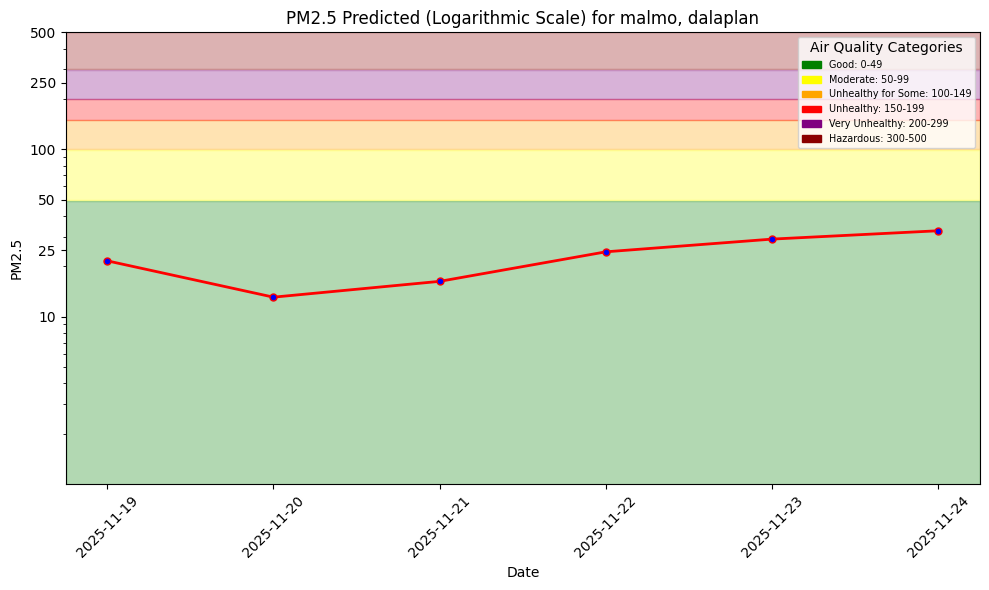

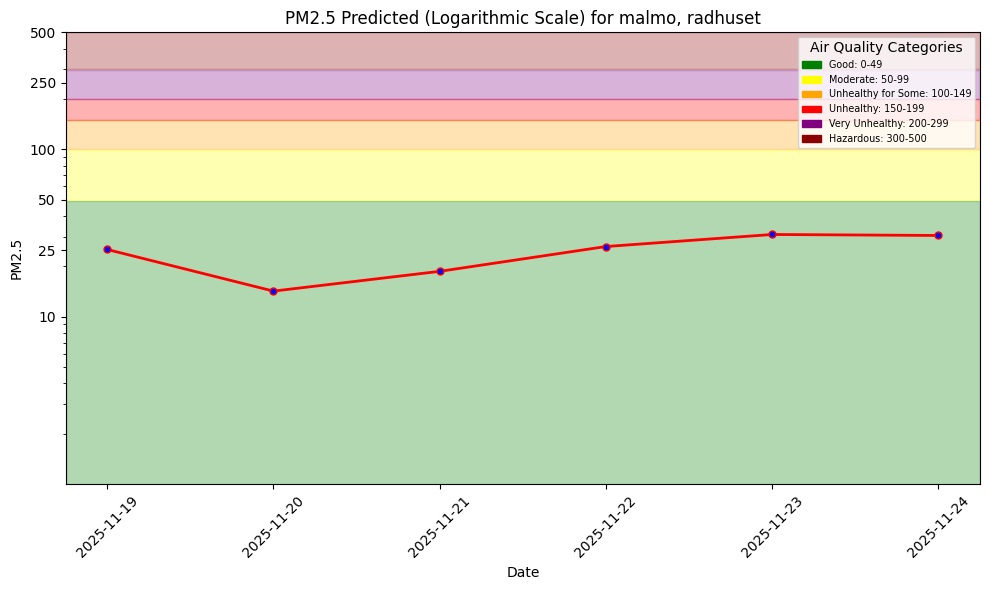

In [18]:
# Assumo che root_dir sia già definita, ad esempio:
# root_dir = os.getcwd()

streets = forecast_df["street"].unique()

for street_name in streets:
    sensor_pred_df = (
        forecast_df[forecast_df["street"] == street_name]
        .sort_values("date")
        .reset_index(drop=True)
    )

    # Path PNG specifico per ogni street
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{street_name}.png"

    # La funzione util.plot_air_quality_forecast si aspetta di trovare 'predicted_pm25' in sensor_pred_df
    plt = util.plot_air_quality_forecast(
        city,
        street_name,
        sensor_pred_df,
        pred_file_path
    )

    plt.show()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.65s) 

📊 Creo hindcast per street: dalaplan
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.66s) 
   ℹ️ Nessun dato per hindcast di 'dalaplan'. Creo grafico coerente con la palette originale.


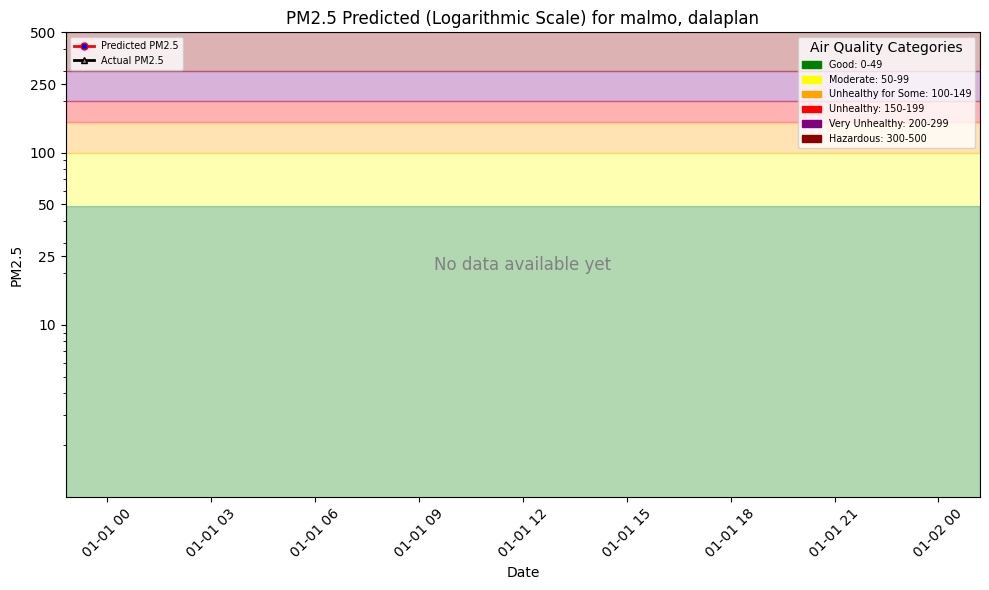

Uploading /Users/emaminotti/ID2223-ScalableMLDL/docs/air-quality/assets/img/pm25_forecast_dalaplan.png: 0.000%…

Uploading /Users/emaminotti/ID2223-ScalableMLDL/docs/air-quality/assets/img/pm25_hindcast_1day_dalaplan.png: 0…


📊 Creo hindcast per street: radhuset
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.53s) 
   ℹ️ Nessun dato per hindcast di 'radhuset'. Creo grafico coerente con la palette originale.


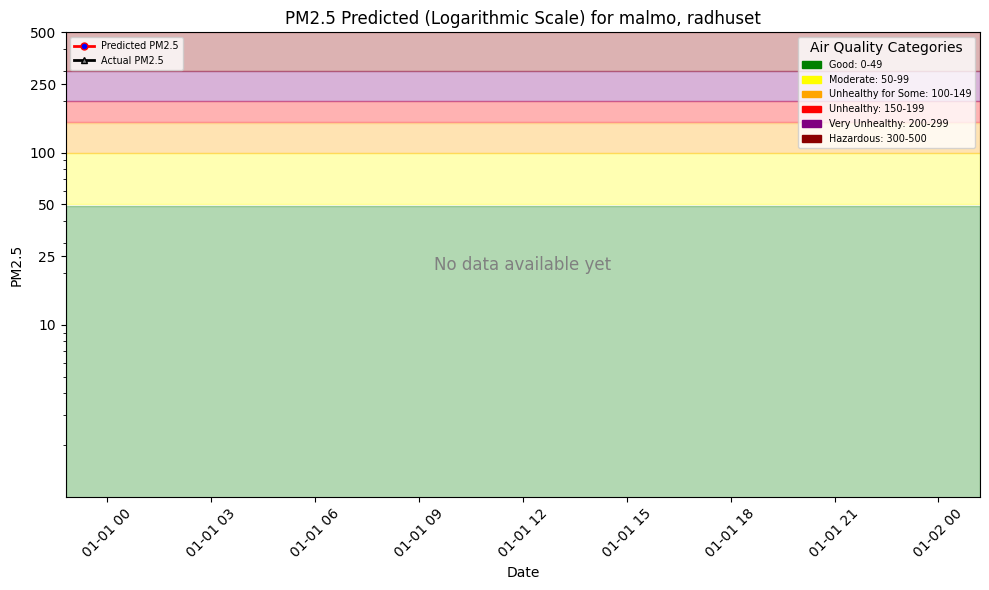

Uploading /Users/emaminotti/ID2223-ScalableMLDL/docs/air-quality/assets/img/pm25_forecast_radhuset.png: 0.000%…

Uploading /Users/emaminotti/ID2223-ScalableMLDL/docs/air-quality/assets/img/pm25_hindcast_1day_radhuset.png: 0…

Vedi le immagini in Hopsworks qui: https://c.app.hopsworks.ai:443/p/1267872/settings/fb/path/Resources/airquality


In [23]:
import matplotlib.pyplot as plt

# Dati reali
air_quality_fg = fs.get_feature_group(name='air_quality', version=2)
air_quality_df = air_quality_fg.read()

dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")

if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")

for street_name in streets:
    print(f"\n📊 Creo hindcast per street: {street_name}")

    # Nome del Feature Group di monitoring per questo sensore
    fg_name = f"aq_predictions_{street_name.lower().replace(' ', '_')}"

    # Feature group di monitoring specifico per la street
    sensor_monitor_fg = fs.get_feature_group(
        name=fg_name,
        version=1,
    )

    # Previsioni fatte 1 giorno prima SOLO per questo sensore
    monitoring_df = sensor_monitor_fg.filter(
        sensor_monitor_fg.days_before_forecast_day == 1
    ).read()

    # Dati reali per questo sensore
    outcome_df = (
        air_quality_df[air_quality_df["street"] == street_name]
        [["date", "pm25"]]
        .copy()
    )

    # Previsioni (1-day ahead) per questo sensore
    preds_df = (
        monitoring_df[monitoring_df["street"] == street_name]
        [["date", "predicted_pm25"]]
        .copy()
    )

    hindcast_df = pd.merge(preds_df, outcome_df, on="date", how="inner")
    hindcast_df = hindcast_df.sort_values("date")

    # Path PNG specifico per l'hindcast di questo sensore
    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{street_name}.png"

    if len(hindcast_df) == 0:
        print(f"   ℹ️ Nessun dato per hindcast di '{street_name}'. Creo grafico coerente con la palette originale.")

        # Creo un DF “vuoto” ma compatibile col plot
        empty_plot_df = pd.DataFrame({
            "date": [today],   # una data placeholder
            "predicted_pm25": [None],  # valore mancante
            "pm25": [None],            # valore reale mancante
        })

        # Uso comunque la funzione di plotting, così mantiene stile, colori, assi…
        plt_obj = util.plot_air_quality_forecast(
            city,
            street_name,
            empty_plot_df,
            hindcast_file_path,
            hindcast=True
        )

        # Aggiungo la scritta “no data available yet”
        ax = plt.gca()
        ax.text(
            0.5, 0.5,
            "No data available yet",
            ha="center", va="center",
            transform=ax.transAxes,
            fontsize=12,
            color="gray"
        )

        plt_obj.savefig(hindcast_file_path, bbox_inches="tight")
        plt_obj.show()
    else:
        # 👉 Dati presenti: uso la funzione util come prima
        plt_obj = util.plot_air_quality_forecast(
            city,
            street_name,
            hindcast_df,
            hindcast_file_path,
            hindcast=True
        )
        plt_obj.show()

    # Upload forecast + hindcast PNG su Hopsworks
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{street_name}.png"

    dataset_api.upload(
        pred_file_path,
        f"Resources/airquality/{city}_{street_name}_{str_today}",
        overwrite=True
    )
    dataset_api.upload(
        hindcast_file_path,
        f"Resources/airquality/{city}_{street_name}_{str_today}",
        overwrite=True
    )

proj_url = project.get_url()
print(f"Vedi le immagini in Hopsworks qui: {proj_url}/settings/fb/path/Resources/airquality")